# Preparar entorno de *trabajo*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
# Escribir su ruta de carpeta de la dataton
ruta_carpeta = '/content/drive/MyDrive/Dataton'

In [1]:
!pip install -q condacolab

In [2]:
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [10]:
!cd /content/drive/MyDrive/Dataton

In [11]:
!conda env update -n base -f environment.yml


EnvironmentFileNotFound: '/content/environment.yml' file not found



# Objetivo

Determinar el precio de las cerezas los meses de Enero a Marzo del 2023

# Imports

In [12]:
import pandas as pd
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Any
from scipy.stats import pearsonr, spearmanr

# Utils

Funciones que serán de utilidad para ejecutar diversas partes del flujo.

Cada función tiene una descripción de lo que hace, el tipo de variables de entrada que requiere y las salidas

In [13]:
def shift(df_origin: pd.DataFrame, important_cols: List[str], n_shifts: int = 8):
    """
    Función encargada de agregar N datos (n_shifts) pasados en una misma fila
    de un dataframe.

    Args:
    df_origin (pd.DataFrame): Dataframe a modificar
    important_cols (List[str]): Lista de columnas a las que se les agregarán los datos pasados
    n_shifts (int): Número de datos pasados a agregar

    Returns:
    pd.DataFrame: Dataframe con las columnas adicionales
    """
    df = copy.deepcopy(df_origin)
    columns_extra = []

    for i in range(1,n_shifts+1):
        for col in important_cols:

            df[f"{col}_{i}"] = df[col].shift(i)
            columns_extra.append(f"{col}_{i}")

    columns_extra = [columns_extra]

    important_cols = important_cols + [item for sublist in columns_extra for item in sublist]

    # reset index
    df.reset_index(drop=True, inplace=True)

    return df[important_cols]

In [14]:
def predict(
    i: int,
    inference: str,
    prediction_df_1: pd.DataFrame,
    model: Any,
    n_shifts: int,
) -> pd.DataFrame:
    """Predecir los datos de un dataframe en la fila i

    Args:
        i (int): indice del dataframe
        inference (str): columna a predecir
        prediction_df_1 (pd.DataFrame): dataframe con los datos a predecir
        model (str): modelo a utilizar
        n_shifts (int): numero de datos pasados a utilizar

    Returns:
        dato (pd.DataFrame): dataframe con los datos predichos
    """

    prediction_df = copy.deepcopy(prediction_df_1)

    dim = prediction_df.shape[0]
    pred = np.nan

    # Check if  colun inference is not null


    flag = pd.isnull(prediction_df.loc[i, f"{inference}"])

    if flag:
        data_to_predict = prediction_df.drop(columns=[f"{inference}"], inplace=False).iloc[i:i+1]
        # print(f"Data to predict {data_to_predict}")
        try:
            pred = model.predict(data_to_predict)

            # every value below 0 is set to 0
            # pred = max(0, pred)

        except Exception as e:
            print(f"Error en predicción {e}")

        for j in range(1, n_shifts+1):
            if dim <= i+j:
                break

            prediction_df.loc[i-j, f"{inference}_{j}"] = pred
    dato = pd.DataFrame(
        data={
            "aux":[0.0],
            f"{inference}": pred,
        }
    )
    return dato

In [15]:
def correlate(df: pd.DataFrame, title: str = "Correlation Heatmap", method: str = 'spearman', threshold: float = 0.5):
    """
    Función encargada de calcular la correlación entre las columnas de un dataframe.

    Args:
    df (pd.DataFrame): Dataframe a analizar
    title (str): Título del heatmap
    method (str): Método de correlación a utilizar (pearson, spearman)
    threshold (float): Umbral de correlación para mostrar los datos

    Returns:
    pd.DataFrame: Dataframe con la correlación
    """

    # Correlación
    correlation_matrix = df.corr(method=method)

    correlated_columns = correlation_matrix[abs(correlation_matrix['PESOTONELADAS']) > threshold].index

    # Select columns of the correlation matrix filtered by correlated columns
    correlation_matrix = correlation_matrix[correlated_columns]

    # Select rows of the correlation matrix filtered by correlated columns
    correlation_matrix = correlation_matrix.loc[correlated_columns]

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", annot_kws={"size": 10})
    plt.title(f'{title}: {method}')
    plt.show()

    return correlation_matrix

In [16]:
def p_value(df: pd.DataFrame, corr_matrix: pd.DataFrame, title: str = "P-Value Heatmap", method: str = 'spearman'):
    """
    Función encargada de calcular el p-value entre las columnas de un dataframe.

    Args:
    df (pd.DataFrame): Dataframe a analizar
    title (str): Título del heatmap

    Returns:
    pd.DataFrame: Dataframe con el p-value
    """

    options = {'spearman': spearmanr, 'pearson': pearsonr}
    method = options[method]

    p_value_matrix = pd.DataFrame(index=corr_matrix.index, columns=corr_matrix.columns)
    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.columns:
            if col1 != col2:
                corr_coef, p_value = spearmanr(df[col1], df[col2])
                p_value_matrix.loc[col1, col2] = p_value


    #Convert NAN to 0
    p_value_matrix = p_value_matrix.fillna(0)

    # Multiply all value by 100
    p_value_matrix = p_value_matrix.astype(float) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(p_value_matrix, cmap='Blues_r', annot=True, fmt=".2f", annot_kws={"size": 10})
    plt.title(f'{title} [PORCENTAJE]')
    plt.show()

    return

In [17]:
def save_to_csv(df: pd.DataFrame, path: str):
    """
    Función encargada de guardar un dataframe en un archivo CSV.

    Args:
    df (pd.DataFrame): Dataframe a guardar
    path (str): Ruta del archivo
    """

    df.to_csv(path, index=False)

In [18]:
def prepare_valid(df_valid_1: pd.DataFrame, df: pd.DataFrame, inference: str, n_shifts: int):
    """
    Función encargada de preparar el dataframe de validación para la predicción.

    Args:
    df_valid (pd.DataFrame): Dataframe de validación
    df (pd.DataFrame): Dataframe original
    inference (str): Columna de inferencia
    n_shifts (int): Número de datos pasados a agregar

    Returns:
    pd.DataFrame: Dataframe de validación preparado
    """

    df_1 = copy.deepcopy(df)
    df_valid = copy.deepcopy(df_valid_1)

    y_valid = df_valid[f'{inference}'] # Guardar la referencia para obtrener métricas de rendimiento

    df_valid[f"{inference}"] = np.nan # Dejar columna a predecir para llenar con las predicciones

    # Obtener fecha más reciente en datos de validación
    last_date = df_valid['timestamp'].min()

    df_pre = df_1[df_1['timestamp'] < last_date] # Tomar los datos anteriores a la fecha más reciente

    df_valid_aux = df_pre[-n_shifts:] # Tomar los últimos n_shifts datos del dataframe de entrenamiento

    df_valid = pd.concat([df_valid_aux, df_valid], axis=0) # Concatenar para que los datos e validación tengan por donde partir

    df_valid.sort_values(by='timestamp', inplace=True)
    df_valid.reset_index(drop=True, inplace=True)

    return y_valid, df_valid

In [19]:
def prepare_test(df_test_1: pd.DataFrame, df: pd.DataFrame, inference: str, important_cols: List[str], n_shifts: int):
    """
    Función encargada de preparar el dataframe de test para la predicción.

    Args:
    df_test (pd.DataFrame): Dataframe de test
    df (pd.DataFrame): Dataframe original
    inference (str): Columna de inferencia
    important_cols (List[str]): Columnas importantes para la predicción
    n_shifts (int): Número de datos pasados a agregar

    Returns:
    pd.DataFrame: Dataframe de test preparado
    """

    df_1 = copy.deepcopy(df)
    df_test = copy.deepcopy(df_test_1)

    important_cols = important_cols + ['timestamp']
    # Seleccionar columnas importantes
    df_1 = df_1[important_cols]
    df_test = df_test[important_cols]

    df_test[f'{inference}'] = np.nan # Dejar columna a predecir para llenar con las predicciones
    # Obtener fecha más reciente en datos de test
    last_date = df_test['timestamp'].min()

    df_pre = df_1[df_1['timestamp'] < last_date] # Tomar los datos anteriores a la fecha más reciente

    df_test_aux = df_pre[-n_shifts:] # Tomar los últimos n_shifts datos del dataframe de entrenamiento

    df_test = pd.concat([df_test_aux, df_test], axis=0) # Concatenar para que los datos e test tengan por donde partir

    df_test.sort_values(by='timestamp', inplace=True)
    df_test.reset_index(drop=True, inplace=True)

    return df_test

In [20]:
def custom_group(df):

    sum_peso = df['PESOTONELADAS'].sum()
    sum_monto = df['MONTOFOB'].sum()
    precio_kg = (sum_monto / sum_peso) / 1000
    return pd.Series([sum_peso, sum_monto, precio_kg], index=['PESOTONELADAS', 'MONTOFOB', 'PRECIO_KG'])


# EDA

In [22]:
# Read data

path = ruta_carpeta + "/Data/02_workshop-data/cerezas_consolidadas.csv"

df = pd.read_csv(path)

## Data conditioning

Primero observarmos los datos, vamos lo que nos es útil y lo que no. ¿Qué nos podría servir para hacer la predicción?

In [23]:
# Quitamos las columnas que creemos que nos serán de utilidad
df_drop = df.drop(columns=["CODARANCELARIO", "SECTOR", "PRODUCTOGRAL", "anio","PRODUCTO", "TIPOOPERACION", "CLASIFICACION"])

Se van guardando los pasos para chequear que lo estamos haciendo bien

In [26]:
save_to_csv(df_drop, ruta_carpeta + "/Debug/1_df_drop.csv")

Se observa que algunas columnas tienen el mismo tipo de datos, pero distinto nombre dependiendo del año. Se agrupan en una sola columna.

In [27]:
# Agrupar columnas que tengan los mismos datos

df_group = copy.deepcopy(df_drop)
df_group["MONTOFOB"] = df_group["MONTOFOB"].fillna(df_group["MONTOFOB(US$)"])
df_group.drop(columns=["MONTOFOB(US$)"], inplace=True)

df_group["REGIONSALIDA"] = df_group["REGIONSALIDA"].fillna(df_group["REGIONORIGEN"])
df_group.drop(columns=["REGIONORIGEN"], inplace=True)

df_group["PUERTOEMBARQUE"] = df_group["PUERTOEMBARQUE"].fillna(df_group["PUNTODECONTROL"])
df_group.drop(columns=["PUNTODECONTROL"], inplace=True)

In [28]:
# Se crea el label de interés

df_group["PRECIO_KG"] = (df_group["MONTOFOB"] / df_group["PESOTONELADAS"]) / 1000

In [29]:
save_to_csv(df_group, ruta_carpeta + "/Debug/2_df_group.csv")

- Nos están pidiendo el precio de las cerezas para el verano del 2023.

- Para hacer una estimación en series de tiempo hay que agrupar las filas que sean de la misma fecha.

    - ¿Qué variables agrupo y cuáles descarto?
    - ¿Qué criterios me van a hacer escoger las variables escenciales?

### Análisis numérico

Se comienza por hacer un análisis de correlación entre las distintas variables que pudiesen influenciar en el precio de las cerezas

In [30]:
# Debido a que hay columnas que son strings, se cambian por columnas booleanas para poder hacer los análisis matemáticos

# One-hot encode categorical variables'
one_hot_encoded = pd.get_dummies(df_group[['PAISDESTINO', 'ADUANA', 'REGIONSALIDA', 'PUERTOEMBARQUE']])
# Se concatenan con variables numéricas
concatenated_df = pd.concat([one_hot_encoded, df_group[['PESOTONELADAS', 'MONTOFOB', 'PRECIO_KG']]], axis=1)

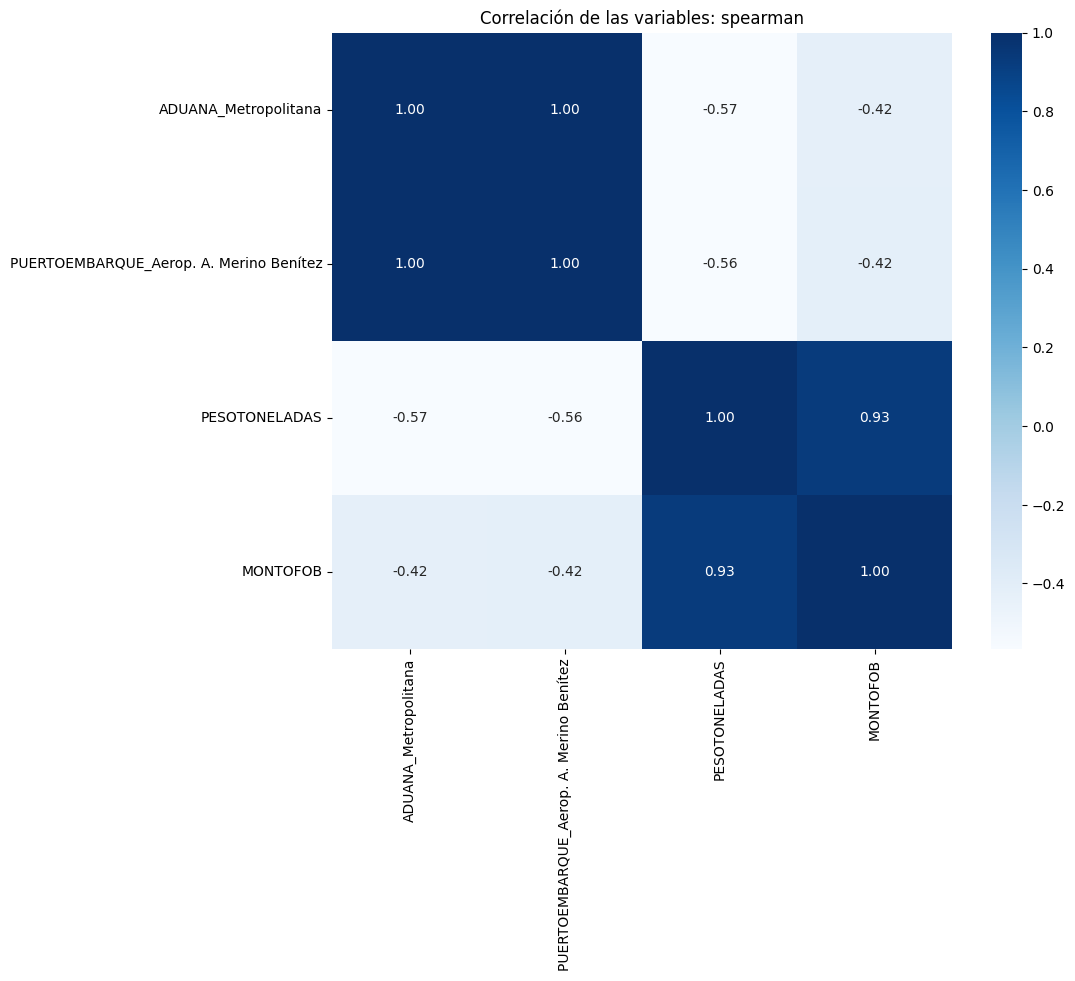

In [31]:
corr_matrix = correlate(concatenated_df, title="Correlación de las variables", method='spearman', threshold=0.5)

Se puede ver que hay una correlación marcada entre el peso y el FOB. Se considera que para las otras variables no es suficientemente fuerte la correlación para incluirlas en la inferencia, por lo tanto se dejan fuera.

Aquí es importante recalcar el uso del criterio por sobre las herramientas matemáticas.

También se puede observar que el precio no está correlacionado a ninguna variable. Sin embargo, por conocimientos sabemos que hay una causalidad directa con las cariables de peso y FOB.

In [32]:
df_time = copy.deepcopy(df_group)
# Se parte por crear un timestamp en base al AÑO y MES entregados para poder agruparlos por fecha

# Dictionary mapping month names to numbers
month_dict = {
    'Enero': 1,
    'Febrero': 2,
    'Marzo': 3,
    'Abril': 4,
    'Mayo': 5,
    'Junio': 6,
    'Julio': 7,
    'Agosto': 8,
    'Septiembre': 9,
    'Octubre': 10,
    'Noviembre': 11,
    'Diciembre': 12
}

# Replace month names with numbers
df_time['MES'] = df_time['MES'].replace(month_dict)

df_time['timestamp'] = pd.to_datetime(df_time['AÑO'].astype(str) + '-' + df_time['MES'].astype(str).str.zfill(2))

df_time.drop(columns=['AÑO', 'MES'], inplace=True)

In [33]:
## Agruparlos por fecha con una función específica para las columnas de interés
df_time = df_time.groupby('timestamp').apply(custom_group).reset_index()

In [34]:
save_to_csv(df_time,ruta_carpeta + "/Debug/3_df_time.csv")

¿Cómo se qué tan bien lo va a hacer mi modelo?

Hay que generar datos de validación para evaluar antes de correrlo directamente en los datos de test

¿Dónde escojo la fecha límite para dividir el entrenamiento y validación?

### Análisis visual

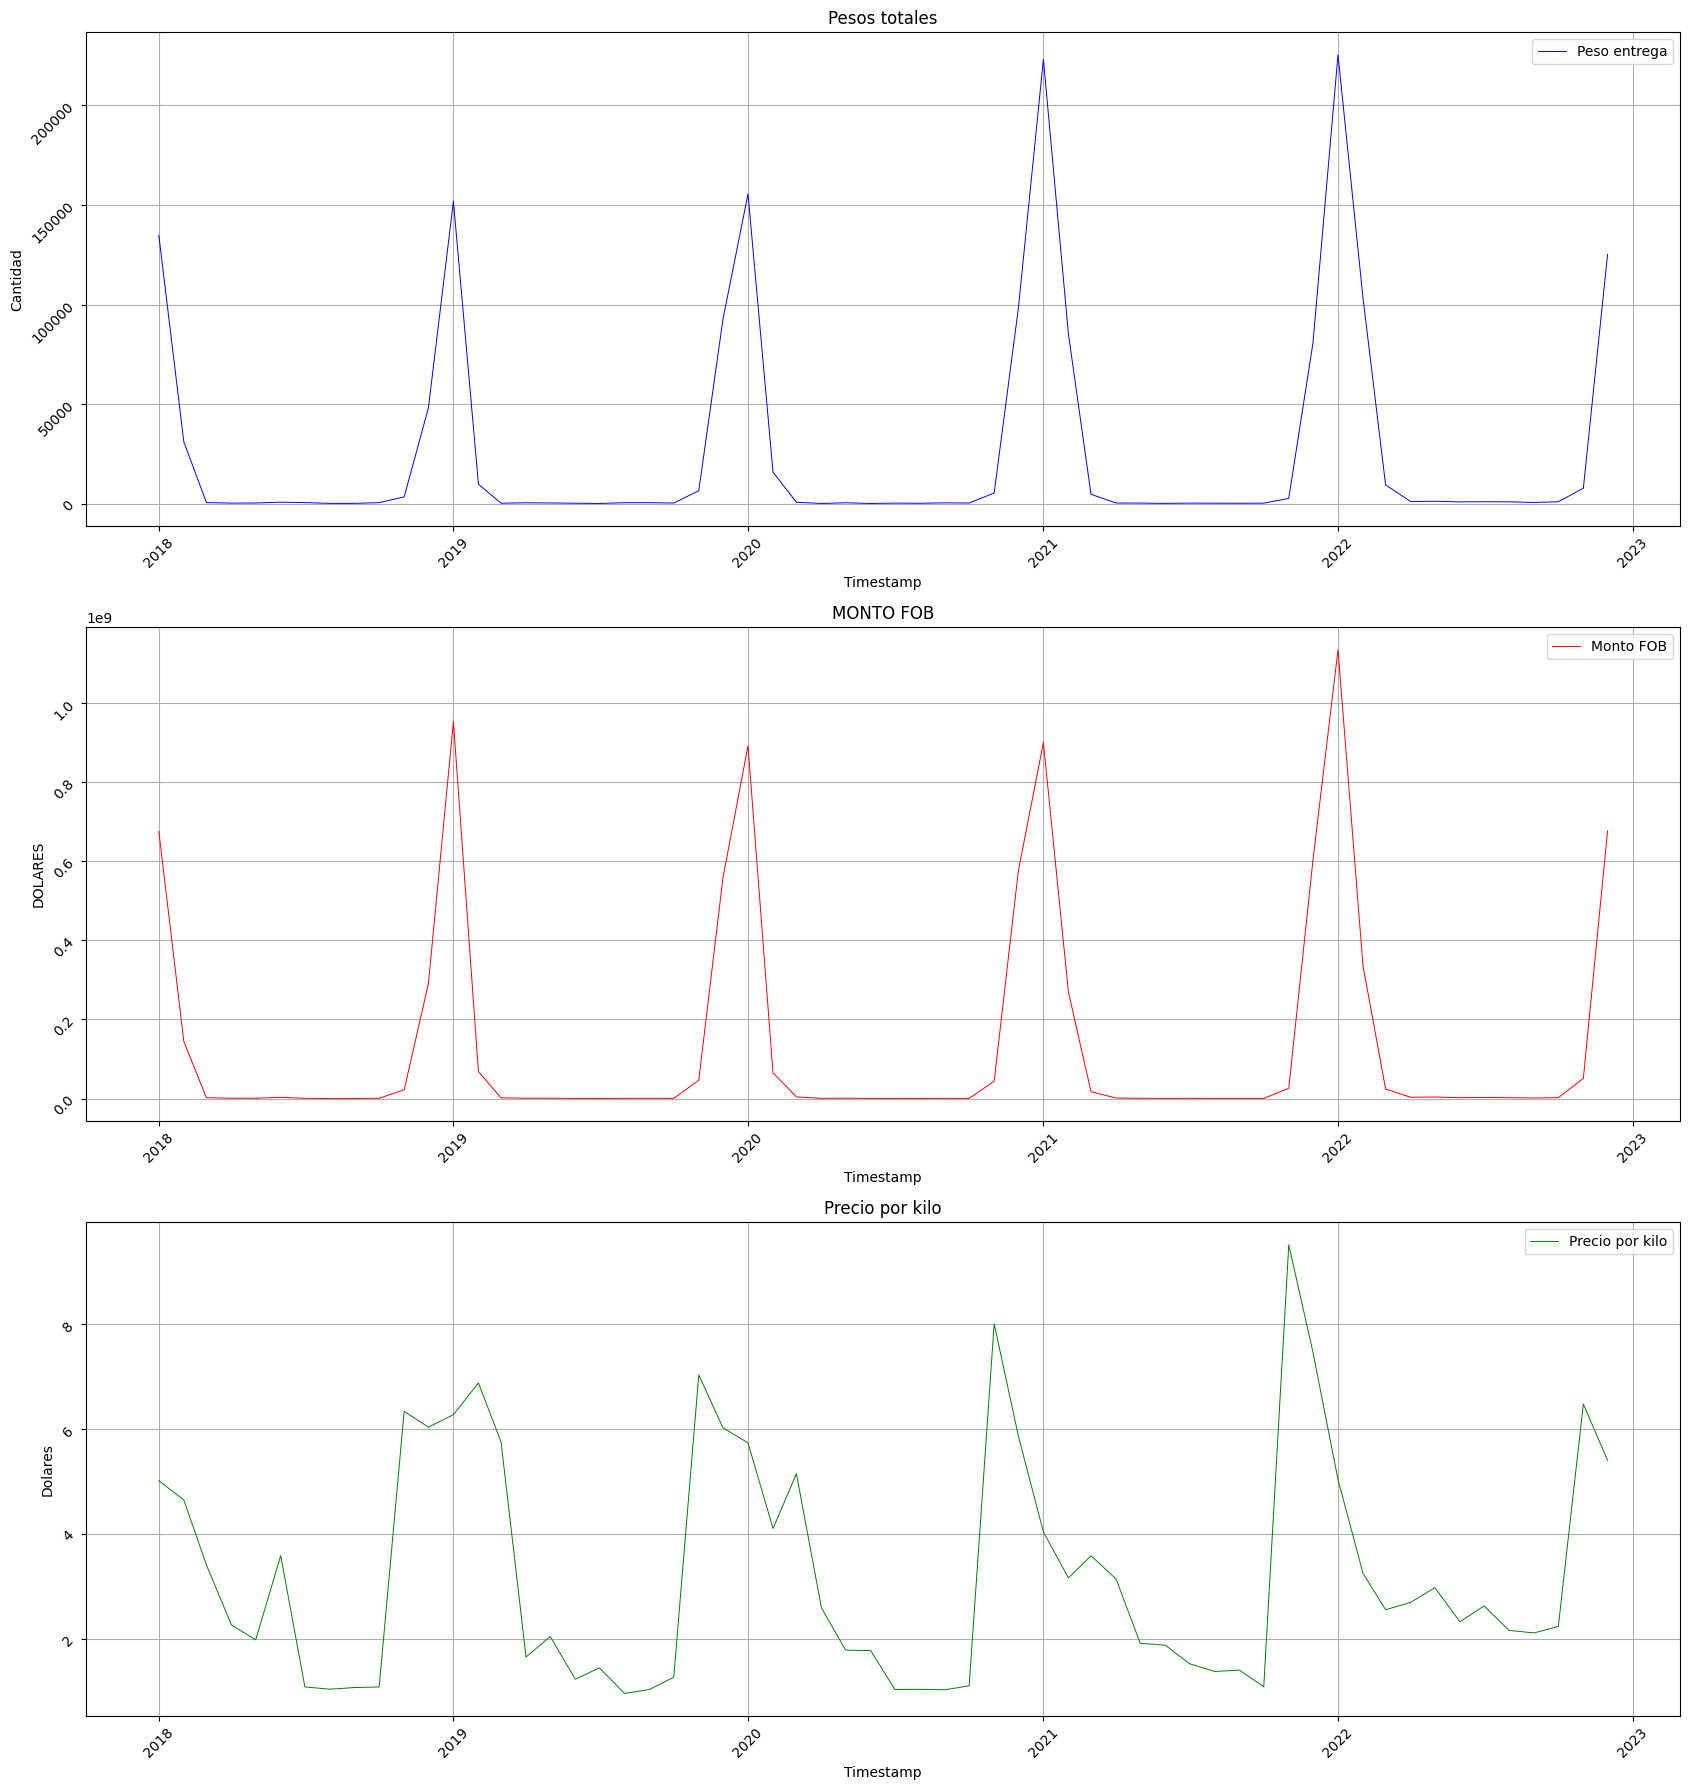

In [35]:
# Plotting
# Create a figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(17, 18))

# Plotting the first plot
axs[0].plot(df_time['timestamp'], df_time['PESOTONELADAS'], label='Peso entrega', linewidth=0.7, color='blue')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Cantidad')
axs[0].set_title('Pesos totales')
axs[0].legend()
axs[0].tick_params(rotation=45)
axs[0].grid(True)

# Plotting the second plot
axs[1].plot(df_time['timestamp'], df_time['MONTOFOB'], label='Monto FOB', linewidth=0.7, color='red')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('DOLARES')
axs[1].set_title('MONTO FOB')
axs[1].legend()
axs[1].tick_params(rotation=45)
axs[1].grid(True)

# Plotting the third plot
axs[2].plot(df_time['timestamp'], df_time['PRECIO_KG'], label='Precio por kilo', linewidth=0.7, color='green')
axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('Dolares')
axs[2].set_title('Precio por kilo')
axs[2].legend()
axs[2].tick_params(rotation=45)
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

En este ejemplo tenemos que dejar una parte para el testeo. Para la competencia los datos de testeo se entregan aparte

In [36]:
train_init = pd.Timestamp('2019-06-15')
valid_init = pd.Timestamp('2021-04-01')
valid_end = pd.Timestamp('2021-12-01')
test_init = pd.Timestamp('2022-04-01')
df_train = df_time[(df_time['timestamp'] > train_init) & (df_time['timestamp'] <= valid_init)].reset_index(drop=True)
df_valid = df_time[(df_time['timestamp'] > valid_init) & (df_time['timestamp'] <= valid_end)].reset_index(drop=True)
df_test = df_time[(df_time['timestamp'] > test_init)].reset_index(drop=True)

Ya tengo los atributos relevantes para entrenar mi modelo. ¿Estos atributos tienen alguna relación con los meses del año?

In [37]:
df_train["MES"] = df_train["timestamp"].dt.month

In [38]:
one_hot_encoded = pd.get_dummies(df_train['MES'])
# Concatenate one-hot encoded columns with
concatenated_df = pd.concat([one_hot_encoded, df_train.drop(columns=['timestamp', 'MES'], inplace=False)], axis=1)

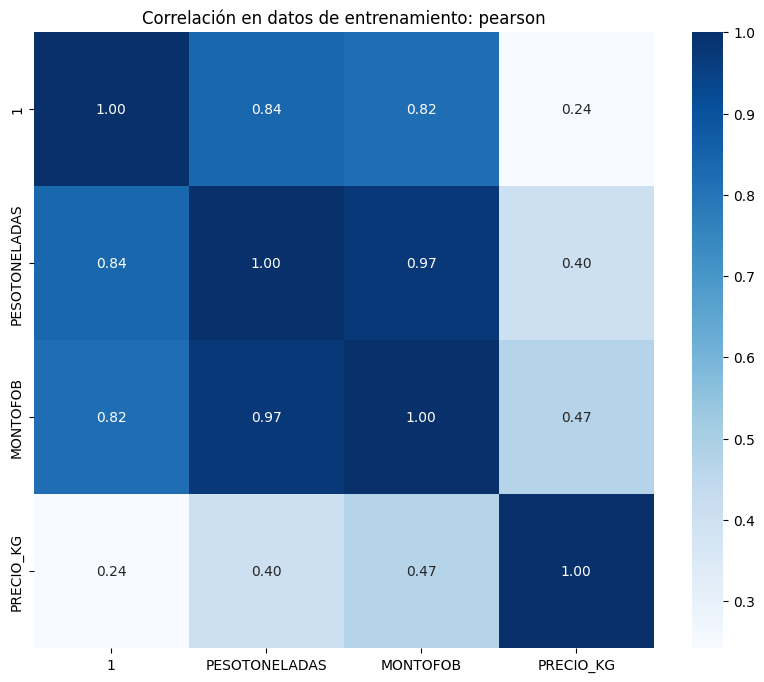

In [39]:
corr_matrix = correlate(concatenated_df, title="Correlación en datos de entrenamiento", method = 'pearson', threshold=0.4)

¿Cómo se qué valores de correlaciones son altos, bajos, me sirven?

Siempre depende del contexto, respecto a las otras variables, capacidades del modelo, etc.

Una buena herramienta que ayuda a entender la significacia es el p-value

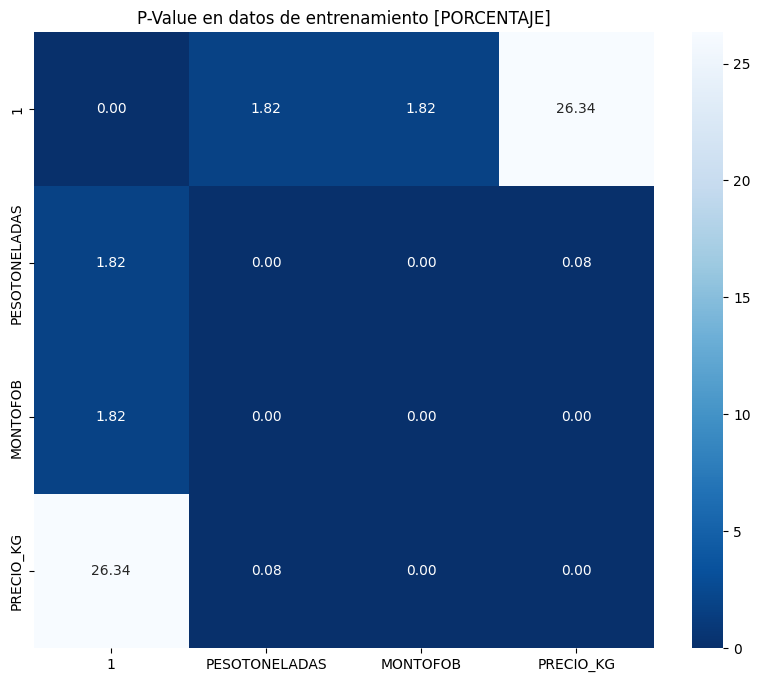

In [40]:
p_value(concatenated_df, corr_matrix, title="P-Value en datos de entrenamiento", method='pearson')

# Train

Definimos las columnas importantes que usaremos para entrenar el modelo. Comenzaremos con una aproximación sencilla

In [41]:
important_cols = ['MES', 'PRECIO_KG']

Ya tenemos los datos necesarios, con la información relevante para entrenar un modelo que aprenda los patrones

In [42]:
# Se define el número de tiempos pasados el modelo va a mirar los datos para hacer una predicción hacia el futuro
n_shifts = 4 # 4 meses en este caso

In [43]:
# Para simplificar la primera versión del modelo, solo se considera el precio y meses en tiempos pasados
df_train_shifted = shift(df_train, important_cols=important_cols, n_shifts = n_shifts)

df_train_shifted.dropna(inplace=True)

In [45]:
save_to_csv(df_train_shifted, ruta_carpeta + "/Debug/4_df_train.csv")

In [46]:
from xgboost import XGBRegressor
import pickle

X_train = df_train_shifted.drop(columns=['PRECIO_KG'])
y_train = df_train_shifted['PRECIO_KG']

model = XGBRegressor(device='cpu', verbosity=2)
model.fit(X_train, y_train)

pickle.dump(model, open('model.pkl', 'wb'))

# Validación de entrenamiento

## Prepare Data

In [47]:
# Asegurarse que el dataframe tenga los mismos atributos que el de entrenamiento

df_valid['MES'] = df_valid['timestamp'].dt.month
df_time['MES'] = df_time['timestamp'].dt.month

In [48]:
save_to_csv(df_valid, ruta_carpeta + "/Debug/5_df_valid.csv")

In [49]:
# Entregarle al dataset de test valores anteriores para que pueda hacer la predicción en los datos de test

y_valid, df_valid_prepared = prepare_valid(df_valid, df_time, inference='PRECIO_KG', n_shifts=n_shifts)

In [50]:
save_to_csv(df_valid_prepared, ruta_carpeta + "/Debug/6_df_valid_prepared.csv")

In [51]:
df_valid_shifted = shift(df_valid_prepared, important_cols, n_shifts = n_shifts)

In [52]:
save_to_csv(df_valid_shifted, ruta_carpeta + "/Debug/7_df_valid_shifted.csv")

## Inference

In [53]:
dim = len(df_valid_shifted)
try:
    y_pred = pd.concat(
        [
            predict(
                i, inference="PRECIO_KG", prediction_df_1 = df_valid_shifted, model = model, n_shifts = n_shifts,
            ) for i in range(dim)
        ]
    )
    y_pred.dropna(inplace=True)
    y_pred.reset_index(drop=True, inplace=True)
    y_pred.drop(columns=['aux'], inplace=True)
    y_valid.reset_index(drop=True, inplace=True)
except Exception as e:
    print(f"Error en pred: {e}")

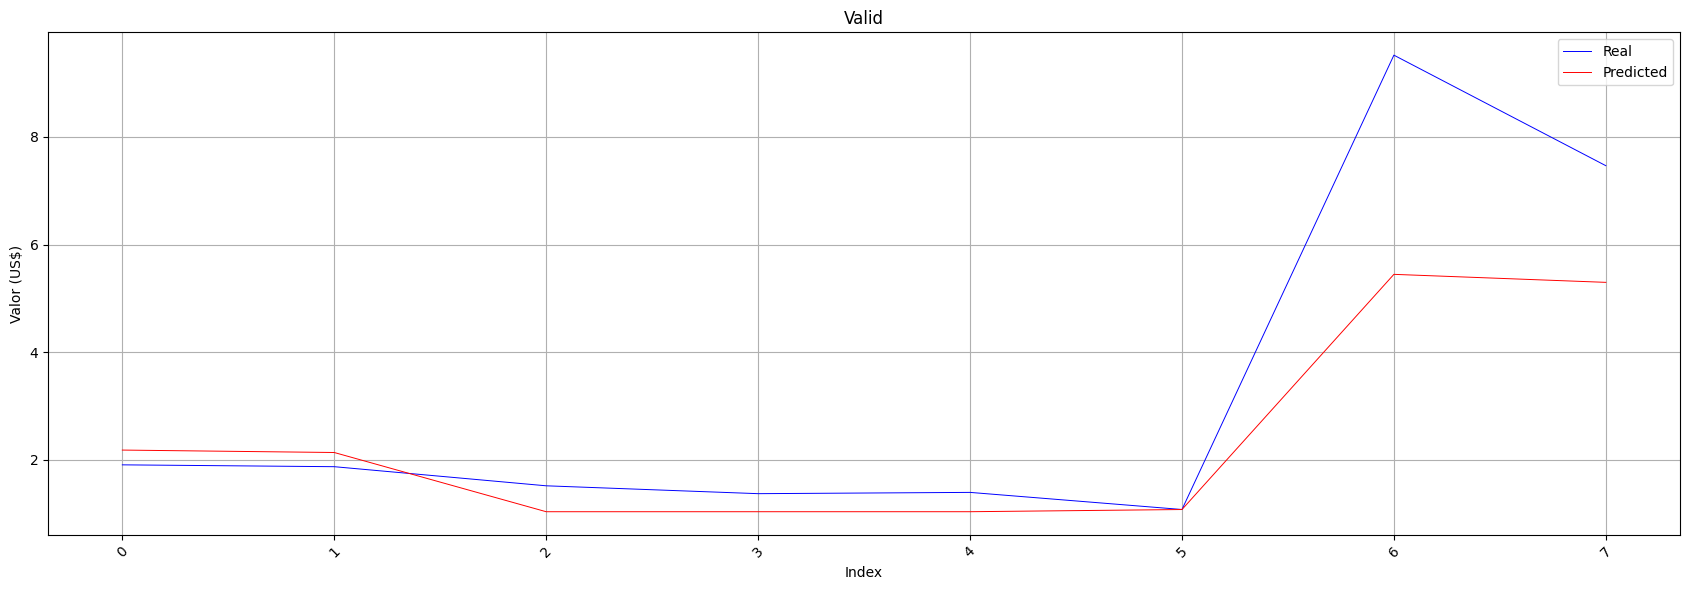

In [54]:
# Plotting
plt.figure(figsize=(17, 6))

plt.plot(y_valid.index, y_valid.values, label='Real', linewidth=0.7, color = 'blue')
plt.plot(y_pred.index, y_pred[f"PRECIO_KG"], label='Predicted', linewidth=0.7, color = 'red')
plt.xlabel('Index')

plt.ylabel('Valor (US$)')
plt.title('Valid')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

# Test

Ejecutar la predicción para la variable de test. En la datatón, tendrán que enviar un CSV con el dataframe rellenado

In [55]:
# Asegurarse que el dataframe tenga los mismos atributos que el de entrenamiento
df_test['MES'] = df_test['timestamp'].dt.month

In [57]:
# Entregarle al dataset de test valores anteriores para que pueda hacer la predicción en los datos de test
df_test_prepared = prepare_test(df_test, df_time, inference='PRECIO_KG', important_cols=important_cols, n_shifts=n_shifts)

In [58]:
df_test_shifted = shift(df_test_prepared, important_cols=important_cols, n_shifts = n_shifts)

In [59]:
dim = len(df_test_shifted)
try:
    y_pred = pd.concat(
        [
            predict(
                i, inference="PRECIO_KG", prediction_df_1 = df_test_shifted, model = model, n_shifts = n_shifts,
            ) for i in range(dim)
        ]
    )
    y_pred.dropna(inplace=True)
    y_pred.reset_index(drop=True, inplace=True)
    y_pred.drop(columns=['aux'], inplace=True)
    y_valid.reset_index(drop=True, inplace=True)
except Exception as e:
    print(f"Error en pred: {e}")

Guardar datos para enviarlos a revisión

In [60]:
df_test['PRECIO_KG'] = y_pred

In [61]:
save_to_csv(df_test, ruta_carpeta + "/Debug/NOMBRE_CORRESPONDIENTE.csv")